# **Experiment 1 | EC69210**
**Code Authors:** Irsh Vijay (21EC39055) and Aditya Raj (21EC39001) \
**References:**
- Total Variation Regularization: https://www-users.cse.umn.edu/~jwcalder/5467/lec_tv_denoising.pdf

**Points to Note:**
- Store .xlsx files in `data/`
- Modify `metadata` dictionary to include other files

### Mandatory Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
from IPython.display import display, clear_output

In [ ]:
!gdown "https://drive.google.com/drive/u/0/folders/1lXFbPKSCF94BFawVVxSrkk5cNEDhr9z2" -O data --folder

Retrieving folder contents
Processing file 16WkpQgdJssMXnHpEULx_0ooKVXTUvjSe DC_noise2.xlsx
Processing file 1Txdm8tDHEvCtYMC_3RS7sfe4yOZYEK3v DC_noise1.xlsx
Processing file 1y-TJSXsEfYqYcajKWme6MI_KJiMdfxVc sinusoid_noise.xlsx
Processing file 1rDs2Uje6W7aEUgU20bcDsMLEh6z_Cfvi ramp_noise.xlsx
Processing file 1fdY9ejPQMoZAUObgoWT70Xh5rd_IpcUM noisy_signal.xlsx
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=16WkpQgdJssMXnHpEULx_0ooKVXTUvjSe
To: /content/data/DC_noise2.xlsx
100% 27.0k/27.0k [00:00<00:00, 70.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Txdm8tDHEvCtYMC_3RS7sfe4yOZYEK3v
To: /content/data/DC_noise1.xlsx
100% 28.5k/28.5k [00:00<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1y-TJSXsEfYqYcajKWme6MI_KJiMdfxVc
To: /content/data/sinusoid_noise.xlsx
100% 20.8k/20.8k [00:00<00:00, 41.0MB/s]
Downloading...
From: https://drive.google.com/uc?

### DataSeries
Contains most of the logic for Ordinary Least Squares and Gradient Descent.

In [ ]:
class DataSeries:
  def __init__(self, path=None, data=None, index=None):
    if path is not None:
      df = pd.read_excel(path, index_col=0)
      self.data = df['y'].to_numpy()
      self.index = df.index.to_numpy()
    else:
      self.data = data
      self.index = np.arange(0, len(self.data)) if index is None else index
    self.logger = MyLogger()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, key):
    return self.data[key]

  def remove_outliers(self):
    self._remove_outliers_global()
    self._remove_outliers_local()

  def _remove_outliers_global(self):
    z = np.abs(self.data - self.data.mean()) / self.data.std()
    self.data = self.data[z < 2]
    self.index = self.index[z < 2]

  def _remove_outliers_local(self, threshold=3, lookback=0.05):
    lookback = int(len(self.data) * lookback)
    index_format = self.index.dtype
    self.index = self.index.astype(float)
    for i in range(lookback, len(self.data)):
        z = np.abs((self.data[i-lookback:i] - self.data[i-lookback:i].mean()) / (self.data[i-lookback:i].std() + 1e-6))
        self.data[i-lookback:i] = np.where(z > threshold, np.nan, self.data[i-lookback:i])
        self.index[i-lookback:i] = np.where(z > threshold, np.nan, self.index[i-lookback:i])
    self.data = self.data[~np.isnan(self.data)]
    self.index = self.index[~np.isnan(self.index)].astype(index_format)


  def plot(self, mode='add', **kwargs):
    plt.plot(self.index, self.data, **kwargs)
    if mode!='add':
      plt.show()

  def least_squares(self, H):
    if isinstance(H, tuple):
      process_params = H[1]
      H = H[0]
      params = np.linalg.inv(H.T @ H) @ H.T @ self.data

      denoised, params = process_params(params, self.data)
      return denoised, params

    params = np.linalg.inv(H.T @ H) @ H.T @ self.data
    denoised = H @ params
    return denoised, params

  def grad_desc(self, H, learning_rate=1e-5, max_iter=int(1e7)):
    if isinstance(H, tuple):
      process_params = H[1]
      H = H[0]
    else:
      process_params = None

    params = np.random.randn(H.shape[1])
    cached_loss = 0

    def lr_scheduling(step, lr_peak_frac=1.2, warm_up_in=0.2):
      warmup_steps = int(max_iter * warm_up_in)
      if step <= warmup_steps:
        return 1 + (step/max_iter /warm_up_in) * (1 - lr_peak_frac)
      return lr_peak_frac * (1 - (1 - 1/lr_peak_frac) * (step - warmup_steps) / (max_iter - warmup_steps))

    for step in tqdm(range(max_iter), desc='Running Gradient Descent'):
      prediction = H @ params
      err = (self.data - prediction)
      loss = np.mean(err ** 2)

      grad = -2 * H.T @ err
      eff_learning_rate = lr_scheduling(step) * learning_rate

      grad_step = eff_learning_rate * grad
      params -=  grad_step

      if np.sum(np.abs(grad_step)) < 1e-8:
        print('Stopped Early')
        break

      self.logger.log_metrics({'loss': loss, 'learning_rate': eff_learning_rate}, step, max_iter)

      cached_loss = loss

    if process_params is None:
      denoised = H @ params
      return denoised, params
    return process_params(params, self.data)


In [ ]:
# Logging Utils

class MyLogger:
  def __init__(self, print_every=100, log_every=1, dynamic=False):
    self.records = []
    self.print_every = print_every
    self.log_every = log_every
    self.dynamic = dynamic

  def log_metrics(self, dictionary, step, max_steps=None):
    if (step+1) % self.log_every == 0:
      dictionary['step'] = step
      self.records.append(dictionary)

    if (step+1) % self.print_every == 0 and self.dynamic:
      clear_output(wait=True)
      display(pd.DataFrame.from_records(self.records[::self.print_every], index='step'))

    if not self.dynamic and step == max_steps-1:
      display(pd.DataFrame.from_records(self.records[::self.print_every], index='step'))

  def plot_run(self, keys=None, log=False):
    df = pd.DataFrame.from_records(self.records, index='step')

    if keys is None:
      keys = df.columns

    for key in keys:
      plt.plot(df[key], label=key)

    if log:
      plt.yscale("log")
    plt.legend()
    plt.show()

### H -> **"The"** Matrix

#### **Least Squares:**

Considering linear model, \
$y = H \cdot \theta$ \

$\theta = (H^T H)^{-1} H^T y$ \
We have different H matrices for different types of functions.

#### Types of `H` Matrices:



1. **Ramp (`kind='ramp'`)**:
- $H =
 \begin{pmatrix}
  1 & x_1 \\
  1 & x_2 \\
  \vdots  & \vdots \\
  1 & x_n
 \end{pmatrix}$
    
- $\theta = [a, b]^T$ where $a$ is the intercept and $b$ is the slope.

2. **DC Component (`kind='dc'`)**:
- $H =
 \begin{pmatrix}
  1 \\
  1 \\
  \vdots \\
  1
 \end{pmatrix}$
    
- $\theta$ is the DC value (interestingly this results in sample mean).

3. **Sine Wave (`kind='sin'`)**:
- $H = \begin{pmatrix}
  \sin(\omega x_1) & \cos(\omega x_1) \\
  \sin(\omega x_2) & \cos(\omega x_2) \\
  \vdots & \vdots \\
  \sin(\omega x_n) & \cos(\omega x_n)
  \end{pmatrix}$
- $\omega = 2 \pi f / 1000$, where $f$ is the target frequency (calculated using FFT).
- $\theta = [A \sin(\phi), A \cos(\phi)]^T$.
- $A$ and $\phi$ are finally calculated using $\sqrt{\theta[0]^2+\theta[1]^2}$ and $arctan2(\theta[1], \theta[0])$


4. **Piecewise (`kind='piecewise'`)**:
- $H = I + \lambda D^TD$
- Where $D$ is a finite difference matrix and $\lambda$ is a regularization parameter in Total Variation Regularization.


In [ ]:
def H(index, kind='ramp', **kwargs):
  if kind == 'ramp':
    return np.stack([np.ones_like(index), index], axis=1)

  elif kind == 'dc':
    return np.ones_like(index)[..., np.newaxis]

  elif kind == 'sin':
    # A*sin(2*pi*f*x/1000 + phi)
    f = kwargs.get('f')
    mult = 2 * np.pi * f / 1000

    H = np.stack([np.sin(mult * index), np.cos(mult * index)], axis=1)

    def process_params(params, y):
      params = [np.sqrt(np.sum(params**2)), np.arctan2(params[1], params[0])]
      denoised = params[0] * np.sin(mult*index + params[1])

      return denoised, params

    return H, process_params

  elif kind == 'piecewise':
    lambda_reg = kwargs.get('lambda_reg')
    if lambda_reg is None:
      raise ValueError('lambda_reg must be provided for "piecewise" kind')

    n = len(index)
    D = np.diff(np.eye(n), axis=0)
    Dx = D @ index

    W = np.diag(1.0 / np.sqrt(Dx**2 + 1e-3))
    H = np.eye(n) + lambda_reg * D.T @ W @ D

    def process_params(params, y):
        denoised = np.linalg.inv(H) @ y
        return denoised, params

    return H, process_params

  else:
    raise ValueError()

In [ ]:
# Helper Functions
def fft_1d(x):
  """
  Recursive FFT function
  """
  n = len(x)

  if not (n & (n - 1)) == 0:
      next_pow_2 = 1 << (n - 1).bit_length()
      x = np.concatenate([x, np.zeros(next_pow_2 - n)])
      n = next_pow_2

  if n <= 1:
      return x

  x_even = fft_1d(x[::2])
  x_odd = fft_1d(x[1::2])

  muls = np.exp(-2j * np.pi * np.arange(n//2) / n) * x_odd

  ans = np.concatenate([
      x_even + muls,
      x_even - muls,
  ])

  return ans

def compute_metrics(denoised1, params1, denoised2, params2):

  def correlation(x, y):
    corr = np.corrcoef(x, y)[0, 1]
    return corr

  return correlation(denoised1, denoised2)

### Driver Code

In [ ]:
# @title Choose Hyperparameters

remove_outliers = True # @param {"type":"boolean","placeholder":"True"}
lambda_reg = 5 # @param {"type":"slider","min":0,"max":100,"step":1}
ramp_learning_rate = -9 # @param {"type":"slider","min":-15,"max":-8,"step":1}
learning_rate = -3 # @param {"type":"slider","min":-6,"max":-1,"step":1}

ramp_learning_rate = 10 ** ramp_learning_rate
learning_rate = 10 ** learning_rate

### **Q1. Signal Estimation using Least Squares**
- Estimate the uncorrupted signals (or signal parameters) from each of the following noisy signals using a suitable Least Squares method.
- Plot the estimated signal on top of the corresponding noisy signal for each case.


Estimated Parameters for 'sin': [5.072263309804039, 1.8494136255968798]


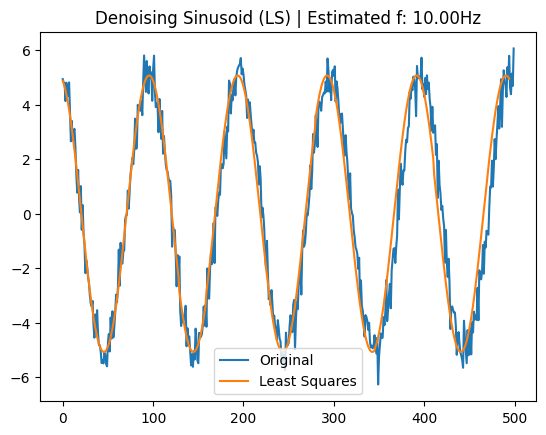

Estimated Parameters for 'dc': [5.00040713]


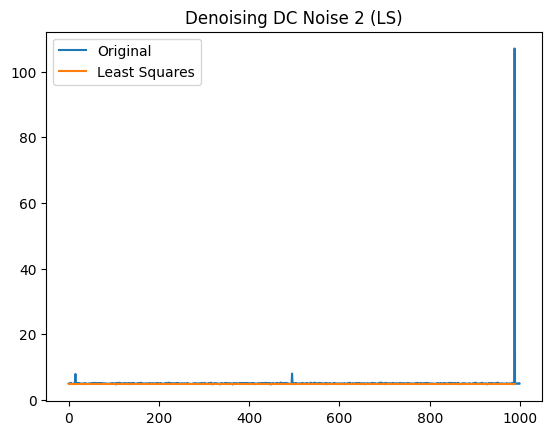

Estimated Parameters for 'piecewise': [ 6.82500949e+00  6.91355367e+00  7.03180514e+00  7.09260871e+00
  7.16547930e+00  7.14474768e+00  7.15333328e+00  7.23526238e+00
  7.16859392e+00  7.10196096e+00  7.03630028e+00  6.94812225e+00
  6.87405507e+00  6.89204719e+00  6.88821598e+00  6.91885836e+00
  6.93409630e+00  6.96039306e+00  6.93794714e+00  6.94336407e+00
  7.10421827e+00  7.17510400e+00  7.16354145e+00  7.10094992e+00
  7.17911067e+00  7.20316931e+00  7.21715805e+00  7.14803636e+00
  7.05371101e+00  7.03122011e+00  7.08826209e+00  7.23906470e+00
  7.20232528e+00  7.17373248e+00  7.18965369e+00  7.19439348e+00
  7.27795370e+00  7.25844453e+00  7.20505682e+00  7.20889191e+00
  7.10084226e+00  7.01484323e+00  6.88645112e+00  6.68486731e+00
  6.44723088e+00  6.02063436e+00  5.40117329e+00  4.61541645e+00
  3.33509369e+00  1.37853665e+00 -1.58248577e+00 -3.56085011e+00
 -4.75173455e+00 -5.55471030e+00 -6.01836854e+00 -6.27611014e+00
 -6.44112948e+00 -6.64344345e+00 -6.77098776e+00 -6.

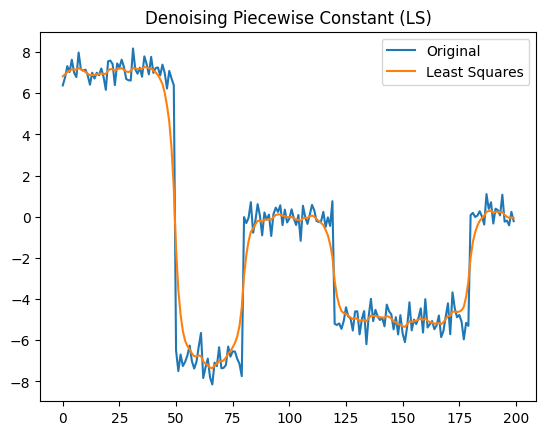

Estimated Parameters for 'ramp': [-35.57160967   2.99171899]


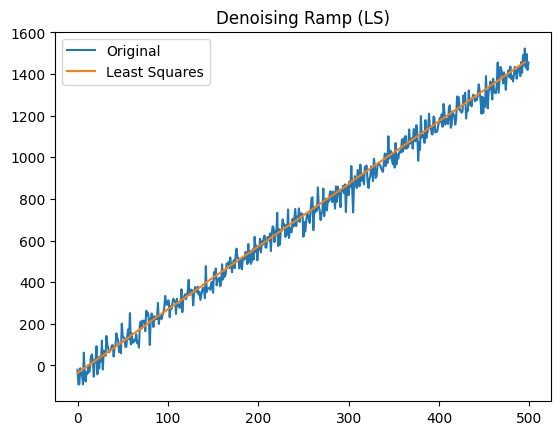

Estimated Parameters for 'dc': [4.99743692]


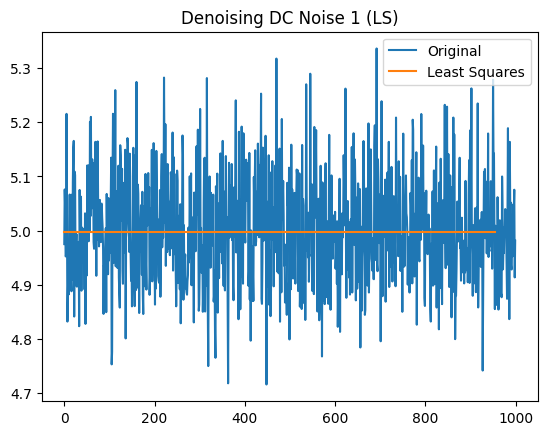

In [ ]:
metadata = {
    'DC_noise1.xlsx': ('dc', 'DC Noise 1'),
    'DC_noise2.xlsx': ('dc', 'DC Noise 2'),
    'noisy_signal.xlsx': ('piecewise', 'Piecewise Constant'),
    'ramp_noise.xlsx': ('ramp', 'Ramp'),
    'sinusoid_noise.xlsx': ('sin', 'Sinusoid')
}
f = None

least_squares_results = []

for pth in os.listdir('data/'):
  ds = DataSeries('data/'+pth)

  kind, pretty_name = metadata[pth]

  if kind == 'sin':
    f = 2*np.argmax(np.abs(fft_1d(ds))[:len(ds)//2])

  ds.plot('add', label='Original')

  if remove_outliers:
    ds.remove_outliers() # Removing Outliers

  H_matrix = H(ds.index, kind, f=f, lambda_reg=lambda_reg)

  ls_denoised, ls_params = ds.least_squares(H_matrix)
  plt.plot(ls_denoised, label='Least Squares')

  least_squares_results.append((ls_denoised, ls_params))

  print(f"Estimated Parameters for '{kind}': {ls_params}")

  plt.title(f'Denoising {pretty_name} (LS)' if kind != 'sin' else f'Denoising {pretty_name} (LS) | Estimated f: {f:.2f}Hz')
  plt.legend()
  plt.show()

### **Q2. Signal Estimation using Gradient Descent**
For the same set of noisy signals , utilize the Gradient Descent approach to estimate the original signals or their parameters. Assume suitable models for the uncorrupted signals and estimate the parameters of these models within the Gradient Descent framework.

Running Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

Stopped Early
Estimated Parameters for 'sin': [5.07226329984608, 1.8494136261351124]


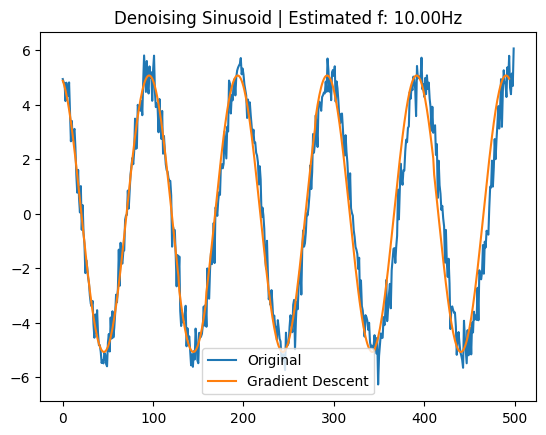

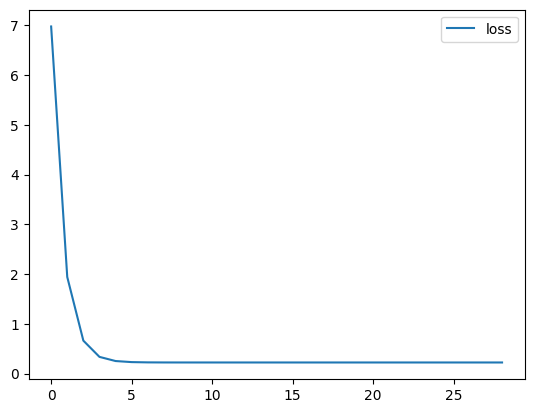

Running Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

Stopped Early
Estimated Parameters for 'dc': [5.00040713]


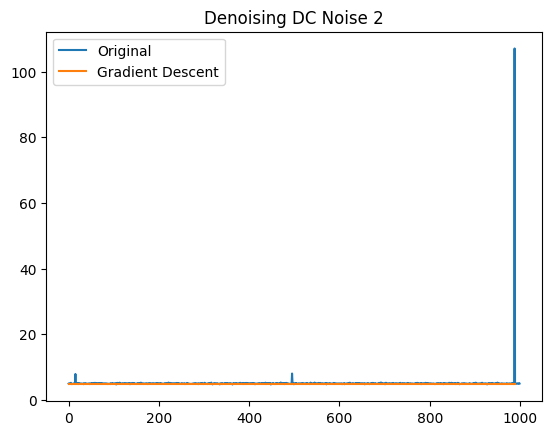

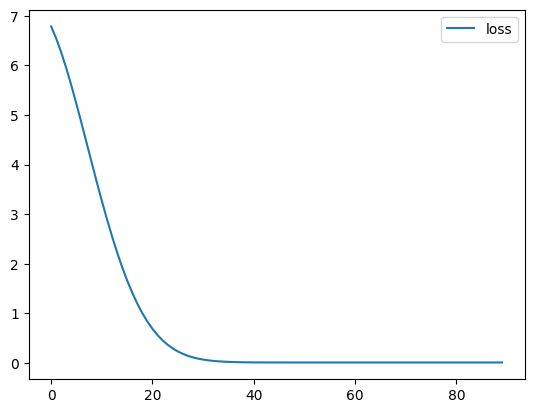

Running Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

,loss,learning_rate
step,,
0,202.077251,1.000000e-09
100,202.057053,8.000000e-10
200,202.030801,1.150000e-09
300,202.005585,1.100000e-09
400,201.981493,1.050000e-09


Estimated Parameters for 'piecewise': [ 0.78020349  0.32088722  0.66242241 -0.2564001   0.10280488 -0.41896499
 -0.80627183 -0.80519724 -0.62535085 -0.30086876  0.22690158 -0.22542701
  1.8266466   0.47852602  0.53697432 -0.09534359  0.19414241  0.18044658
 -0.85202376 -0.09007521  0.72803843 -0.23500786 -1.04576101  1.64650993
  1.08590976 -0.81471249  1.01609754  0.02230724  1.76411367 -1.47064933
 -0.5458736  -0.90097501  1.83692377  1.03717409 -0.19643633  2.18555992
 -1.38732574 -0.08665934  0.27721572  0.55335872  0.45245243  1.90418588
 -0.89898938  1.7174951  -0.08076906  0.82171094  0.12683236 -0.72313746
 -0.42428301 -0.05922849 -0.22932545  1.23520446  0.59440733 -0.57603499
 -0.75637608 -2.19889876 -0.88365525 -0.25295524  0.63983707  1.05293185
  0.58100115  0.25206945 -0.75113587  0.30261795  1.30750613 -2.01890745
 -0.25375262  0.64758637  0.86419958  0.57034272 -1.34546523  1.48043489
  1.14189831 -0.72533421  1.04595234 -0.42745223 -1.19007992  0.51699456
  0.86470977 

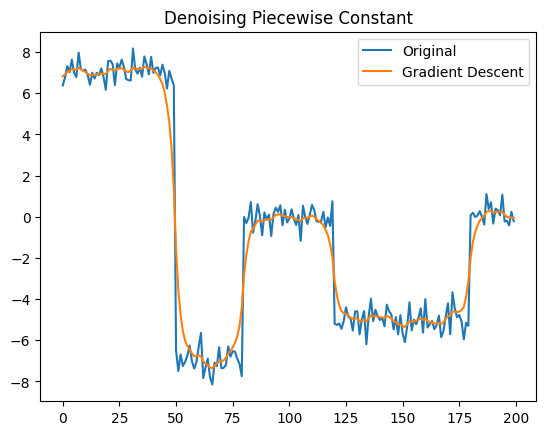

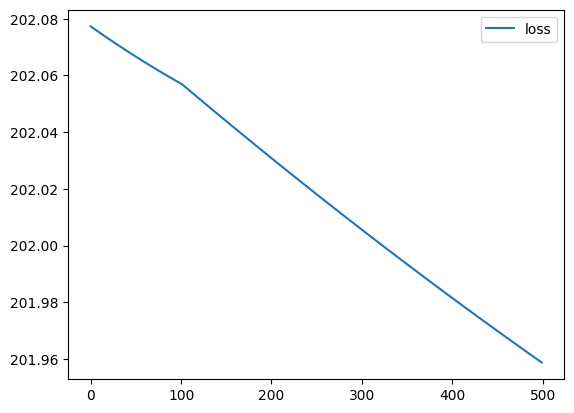

Running Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

,loss,learning_rate
step,,
0,1.558249e+06,1.000000e-09
100,1.797367e+03,8.000000e-10
200,1.797064e+03,1.150000e-09
300,1.797047e+03,1.100000e-09
400,1.797030e+03,1.050000e-09


Estimated Parameters for 'ramp': [-0.0481235  2.8852266]


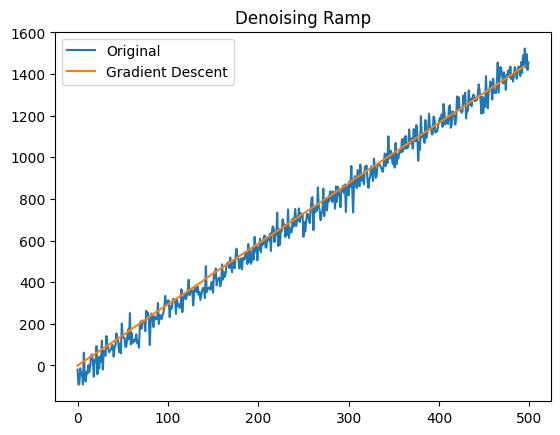

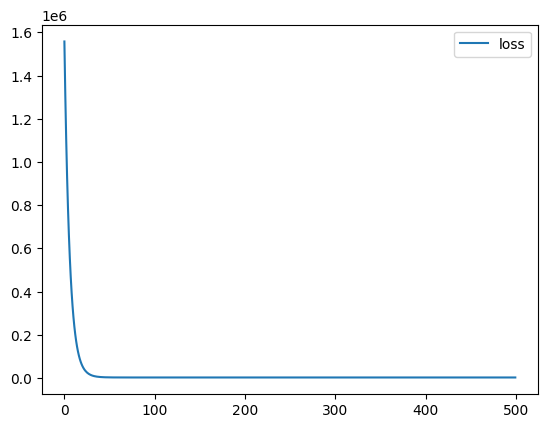

Running Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

Stopped Early
Estimated Parameters for 'dc': [4.99743692]


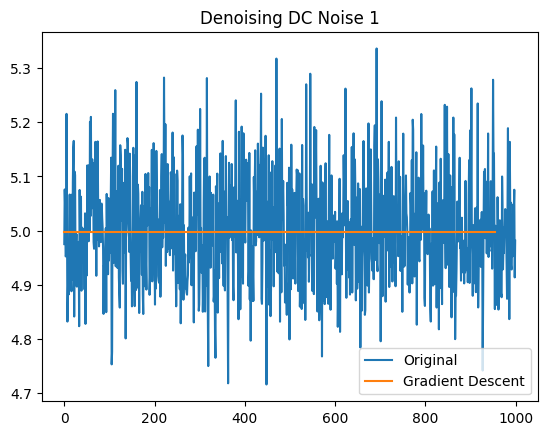

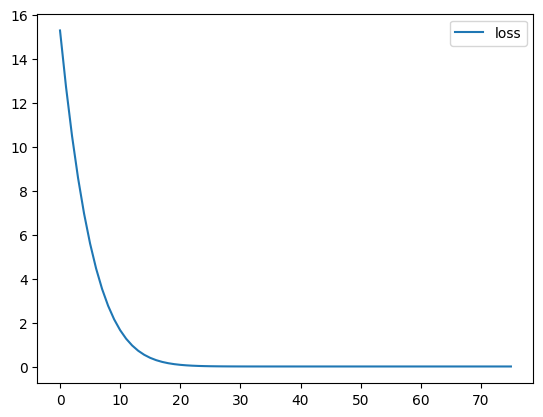

In [ ]:
gradient_descent_results = []

for pth in os.listdir('data/'):
  ds = DataSeries('data/'+pth)

  kind, pretty_name = metadata[pth]

  if kind == 'sin':
    # Sine Max Freq
    f = 2*np.argmax(np.abs(fft_1d(ds))[:len(ds)//2])

  ds.plot('add', label='Original')
  ds.remove_outliers() # Removing Outliers
  # ds.plot('add')

  H_matrix = H(ds.index, kind, f=f, lambda_reg=lambda_reg)

  gd_denoised, gd_params = ds.grad_desc(H_matrix, learning_rate=ramp_learning_rate if kind in ['ramp', 'piecewise'] else learning_rate, max_iter=500)
  plt.plot(gd_denoised, label='Gradient Descent')


  gradient_descent_results.append((gd_denoised, gd_params))

  print(f"Estimated Parameters for '{kind}': {gd_params}")

  plt.title(f'Denoising {pretty_name}' if kind != 'sin' else f'Denoising {pretty_name} | Estimated f: {f:.2f}Hz')
  plt.legend()
  plt.show()

  ds.logger.plot_run(keys=['loss'])

Compare the estimates obtained from the Least Squares method with those obtained from the Gradient Descent approach for each of the noisy signals.

Results are shifted by 5 for better visualization
Correlation: 100.00%


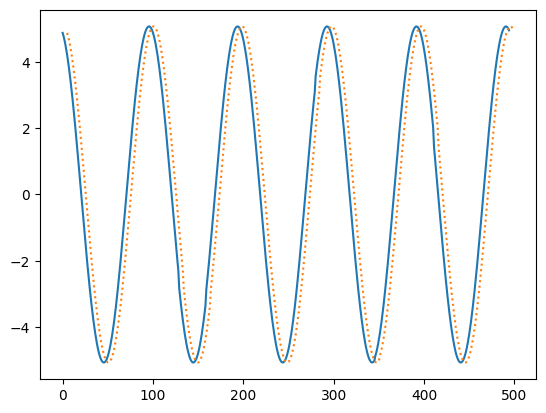

Correlation: nan%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


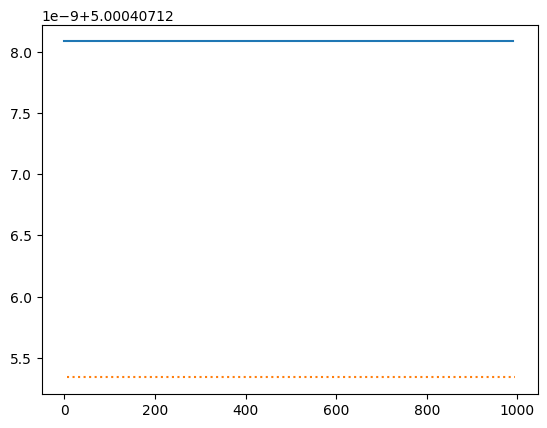

Correlation: 100.00%


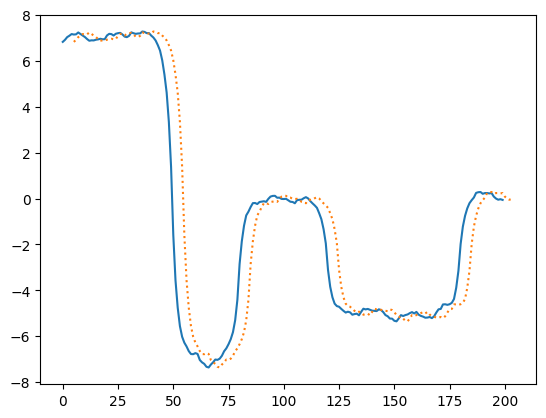

Correlation: 100.00%


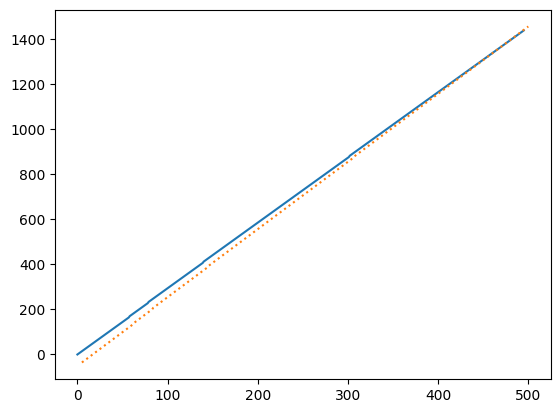

Correlation: nan%


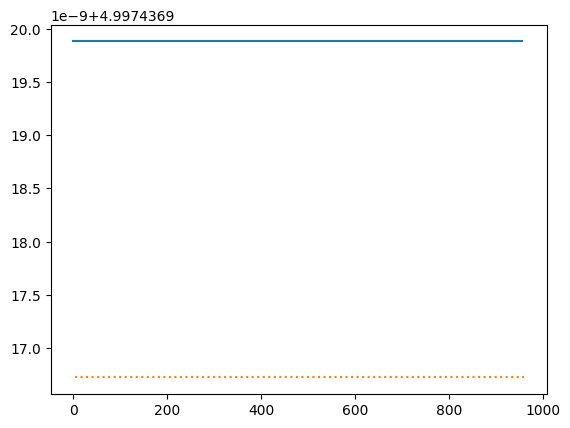

In [ ]:
print("Results are shifted by 5 for better visualization")
for gd, ls in zip(gradient_descent_results, least_squares_results):
  gd_denoised, gd_params = gd
  ls_denoised, ls_params = ls

  print(f"Correlation: {compute_metrics(*gd, *ls):.2%}", )

  idx = np.arange(0, len(gd_denoised))
  plt.plot(idx, gd_denoised, label='Gradient Descent')
  plt.plot(idx+5, ls_denoised, label='Least Squares', linestyle='dotted')
  plt.show()